In [1]:
import tensorflow as tf

In [2]:
# adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage

In [5]:
import PIL
from PIL import Image

In [6]:
# Problem parameters
num_img = 20 # number of images used in training
max_color = 7 # number-1 of possible colors for the images (8 gradations of gray)
janela = 7 # dimension of the windows taken from the images to be restored used by the model
num_data = 250*250*num_img # quantity of samples from 20 images of 256x256 resolution

In [7]:
"""" Code by Lucas Antunes Rodrigues
     Contact: lucas.antunes.rodrigues@usp.br """

# Preparing training data
data2 = np.zeros((num_data, np.square(janela)))
labels2 = np.zeros((num_data, 1))
contador = 0

# Images degraded by sigma = 2 and dimension = (7, 7) (gaussian blur)
for i in range (1, num_img + 1):
    degradada = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada' + str(i) + '.npy')
    original = np.load('dataset_gray/original/8/arrays/original' + str(i) + '.npy')
    
    for pixel_i in range(int((janela-1)/2), original.shape[0] - int((janela-1)/2)):
        for pixel_j in range(int((janela-1)/2), original.shape[0] - int((janela-1)/2)):
            if len(degradada.shape) == 2:
                crop = degradada[pixel_i - int((janela-1)/2):pixel_i + int((janela-1)/2) + 1,
                                 pixel_j - int((janela-1)/2):pixel_j + int((janela-1)/2) + 1]
                label = original[pixel_i, pixel_j]
            
            data2[contador, :] = np.asmatrix(crop.flatten())
            labels2[contador, :] = np.asmatrix(label)
            contador = contador + 1

In [8]:
"""" Code by Lucas Antunes Rodrigues
     Contact: lucas.antunes.rodrigues@usp.br """

# Preparing test data
# Images degraded by sigma = 2 and dimension = (7, 7) (gaussian blur)
original = np.load('dataset_gray/original/8/arrays/original.npy')
degradada = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada.npy')
test_data2 = np.zeros((250*250, np.square(janela)))
test_labels2 = np.zeros((250*250, 1))
contador = 0
for pixel_i in range(int((janela-1)/2), original.shape[0] - int((janela-1)/2)):
    for pixel_j in range(int((janela-1)/2), original.shape[0] - int((janela-1)/2)):
        if len(degradada.shape) == 2:
            crop = degradada[pixel_i - int((janela-1)/2):pixel_i + int((janela-1)/2) + 1,
                             pixel_j - int((janela-1)/2):pixel_j + int((janela-1)/2) + 1]
            label = original[pixel_i, pixel_j]

        test_data2[contador, :] = np.asmatrix(crop.flatten())
        test_labels2[contador, :] = np.asmatrix(label)
        contador = contador + 1

In [9]:
"""" Code by Lucas Antunes Rodrigues
     Contact: lucas.antunes.rodrigues@usp.br """

# Creating model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers

labels = np.rint(labels2)
t_labels = np.rint(test_labels2)
train_labels = tf.keras.utils.to_categorical(labels2, num_classes=max_color + 1)
train_data = data2
test_labels = tf.keras.utils.to_categorical(test_labels2, num_classes=max_color + 1)
test_data = test_data2

model = Sequential()

model.add(Dense(40,input_dim = np.square(janela)))
model.add(Activation('relu'))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(8))
model.add(Activation('softmax'))

opt = optimizers.Adam(lr=0.001,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=None,
                      decay=0.0,
                      amsgrad=False)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

history = model.fit(train_data, train_labels, epochs=100, batch_size=512)

score = model.evaluate(x=test_data, y=test_labels, batch_size=1)

test_output = model.predict(test_data, batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                2000      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 328       
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
Total params: 3,968
Trainable params: 3,968
Non-trainable params: 0
______________________________________________________

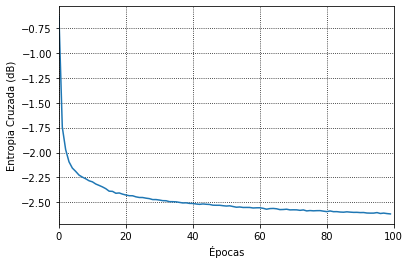

In [10]:
# Plotting loss
plt.plot(10*np.log10(history.history['loss']))
plt.xlim(0,100)
plt.ylabel('Entropia Cruzada (dB)')
plt.grid(color='black', linestyle='dotted')
plt.xlabel('Épocas')
plt.savefig('saved/mlp_adam/error.eps', format='eps')
plt.show()

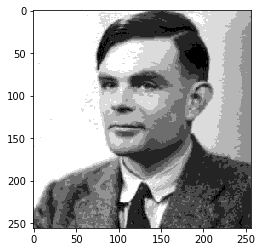

In [11]:
# Original picture from testing data
original = np.load('dataset_gray/original/8/arrays/original.npy')
plt.imshow(original, 'gray')

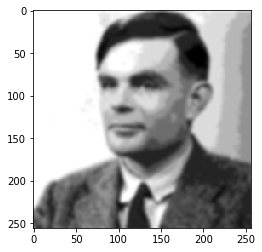

In [12]:
# Degraded picture
degradada = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada.npy')
plt.imshow(degradada, 'gray')

In [13]:
original_tf = tf.convert_to_tensor(np.expand_dims(original, axis=2), np.float64)
degradada_tf = tf.convert_to_tensor(np.expand_dims(degradada, axis=2), np.float64)

In [14]:
# SSIM between original and degraded pictures
tf.image.ssim(original_tf, degradada_tf, max_val=7).numpy()

0.7746411

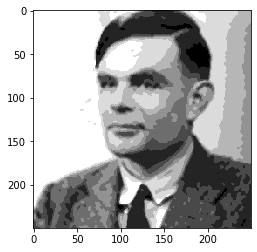

In [15]:
# Restored picture
rest = np.argmax(test_output, axis=1).reshape((original.shape[0] - (janela - 1), original.shape[0] - (janela - 1)))
rest = np.rint(rest)
plt.imshow(rest, cmap = 'gray')
Image.fromarray(32*rest.astype(np.uint8), mode='L').save('saved/mlp_adam/rest.eps')

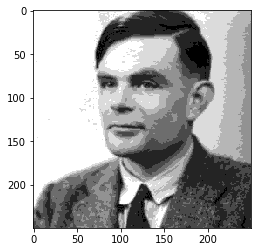

In [16]:
# Reshaping original picture for SSIM comparison
original_aux = original[3:253, 3: 253]
plt.imshow(original_aux, cmap = 'gray')

In [17]:
original_aux_tf = tf.convert_to_tensor(np.expand_dims(original_aux, axis=2), np.float64)
rest_tf = tf.convert_to_tensor(np.expand_dims(rest, axis=2), np.float64)

In [18]:
# SSIM between original and restored pictures
tf.image.ssim(original_aux_tf, rest_tf, max_val=7).numpy()

0.83345765

In [19]:
# Saving model
model.save('saved/mlp_adam/model.h5')